# **CSE 7324 Lab 2: Exploring Image Data**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
------

### **1. Business Understanding**
------

We chose dataset on Kaggle website https://www.kaggle.com/grassknoted/asl-alphabet. The dataset is a collection of images for training of American Sign Language (ASL). It contains 87,000 images of 200x200 pixels each. There are 29 classes of 3000 images each from the English alphabets A-Z, SPACE, DELETE and NOTHING. 

Based on National Center for Health Statistics https://www.startasl.com/american-sign-language, there are approximately 28 million Americans (10% of the population) with some degree of hearing loss, of which 2 million people are classified as deaf. Moreover, half a million deaf people in American and Canada are using ASL as their natural language. Nowadays, ASL becomes the third most common language in the United States. 

Since there are a large population of hearing loss people, the ASL data is helpful in real life applications and in classifications. It creates a bridge between people with different languages to communicate, especially for the communication between hearing loss people and hearing people. Some companies provided service to help deaf people to communicate well with hearing people such as Sorenson Video Relay Service (SVRS). They are using a ASL interpreter, who is fluent in ASL and English or Spanish speaking, to relay the conversation between the deaf and hearing people.

Our prediction task for this dataset is to classify and link gestures with words and try to anticipate the following words based on the contex. We also can predict mistakes in performance which may lead to conversation misunderstanding. Companies like SVRS would be interested in our project. They can use machine translator instead of human interpreter to relay conversations between two parites.


### **2. Data Preparation**
------

In [1]:
# import dependencies

import sys
import os
from time import time
from time import sleep
from PIL import Image
import numpy as np
import pandas as pd


In [5]:
# helper functions to load and save images

def load_image(image):
    img = Image.open(image)
    img.load()
    npimage = np.asarray(img, dtype="int32")
    return npimage

def save_image(npimage, filename):
    img = Image.fromarray(np.asarray(np.clip(npimage, 0, 255), dtype="uint8"), "L")
    img.save(filename)

In [40]:
for root, dirs, files in os.walk('Data/Dataset/'):
    for file in files:
        pass

### **3. Data Reduction**
------

### **4. Feature Extraction with ORB Key Point Matching**
------

In [41]:
# dependencies
import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt


I have 2900 images and 2900 targets


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


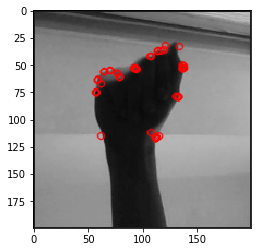

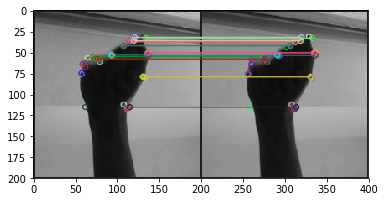

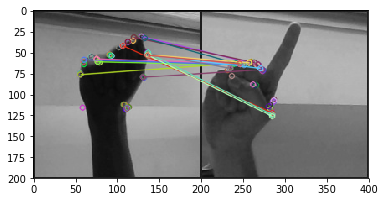

(<matplotlib.image.AxesImage at 0x7fec7e7fada0>, None)

In [53]:
%time

# initiate STAR Detector
orb = cv2.ORB_create()

# read in two images for ORB testing
img = cv2.imread('Data/asl_alphabet_train/A/A1.jpg', 0)
img2 = cv2.imread('Data/asl_alphabet_train/A/A2.jpg', 0)
img3 = cv2.imread('Data/asl_alphabet_train/Z/Z1.jpg', 0)

# find key points and compute descriptors
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(img2, None)
kp3, des3 = orb.detectAndCompute(img3, None)

# draw keypoints location
kpimg = cv2.drawKeypoints(img, kp1, img, color=(255,0,0), flags=0)
plt.imshow(kpimg),plt.show()

# create brute force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# match descripters computed for image 1 and 2 (same sign)
matches = bf.match(des1, des2)

# sort matches by distance
matches = sorted(matches, key=lambda x:x.distance)

# draw first 15 matches
img = cv2.drawMatches(img, kp1, img2, kp2, matches[:15], img, flags=0)
plt.imshow(img),plt.show()

# match descripter computed for image 2 and 3 (one with no sign)
matches2 = bf.match(des2, des3)
matches2 = sorted(matches, key=lambda x:x.distance)
img2 = cv2.drawMatches(img2, kp2, img3, kp3, matches[:15], img2, flags=0)
plt.imshow(img2),plt.show()

The above code is an example of using ORB to get the keypoints of an image and compare to other images. The second image shows the key points on two images of the same sign whereas the third picture shows the matching keypoints on different signs.

In [190]:
# helper function for sampling images for training
def sample_directories(num_samples, directory):
    file_sample = []
    target = []
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            for sample in random.sample(os.listdir(root+dir+'/'), num_samples):
                file_sample.append(root+dir+'/'+sample)
                target.append(dir)
    return file_sample, target

# training data
images, target = sample_directories(100, 'Data/asl_alphabet_train/')

print('I have {} images and {} targets in my training data'.format(len(images), len(target)))

# class to hold ORB keypoints and descriptors
class ImageORB:
    def __init__(self, img, kp, des):
        self.img = img
        self.kp = kp
        self.des = des
        
    def matches(self, des):
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        return bf.knnMatch(self.des, des, k=5)
    
    def getdes(self):
        return self.des
    
class ImageTest(ImageORB):
    def __init__(self, img, kp, des):
        super().__init__(img, kp, des)  
        
    def setDistance(self, distance):
        self.distance = distance
        
    def BestMatch(self, bestmatch):
        self.bestmatch = bestmatch

I have 2600 images and 2600 targets in my training data


In [218]:
# compute key points and descripters for each image

max_des_shape = 0

# training images
training_images = []
for image in images:
    img = cv2.imread(image, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    training_images.append(ImageORB(img, kp, des))
    
# tst images   
test_images = []
for root, dirs, files in os.walk('Data/asl_alphabet_test/'):
    for file in files:
        test_images.append(root+file)
       
test_img_objs = []
for test_img in test_images:
    img = cv2.imread(test_img, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    test_img_objs.append(ImageTest(img, kp, des))

# build training set array
training_data = np.empty((1, max_des_shape), dtype=float)
# flatten all des and reshape into single row
for image in training_images:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    training_data = np.vstack((training_data, desarr))

training_data = np.delete(training_data, 0, 0)
 
# build test set array
test_data = np.empty((1, max_des_shape), dtype=float)
for image in test_img_objs:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    test_data = np.vstack((test_data, desarr))

test_data = np.delete(test_data, 0, 0)


In [221]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(training_data, target)
print(nn.predict(test_data))
for file in test_images:
    print(file)

['G' 'F' 'E' 'K' 'O' 'A' 'B' 'G' 'C' 'N' 'C' 'B' 'Z' 'J' 'P' 'A' 'E' 'X'
 'N' 'H' 'A' 'N' 'H' 'J' 'O' 'J']
Data/asl_alphabet_test/I_test.jpg
Data/asl_alphabet_test/F_test.jpg
Data/asl_alphabet_test/M_test.jpg
Data/asl_alphabet_test/U_test.jpg
Data/asl_alphabet_test/P_test.jpg
Data/asl_alphabet_test/S_test.jpg
Data/asl_alphabet_test/R_test.jpg
Data/asl_alphabet_test/G_test.jpg
Data/asl_alphabet_test/C_test.jpg
Data/asl_alphabet_test/E_test.jpg
Data/asl_alphabet_test/Q_test.jpg
Data/asl_alphabet_test/Z_test.jpg
Data/asl_alphabet_test/B_test.jpg
Data/asl_alphabet_test/Y_test.jpg
Data/asl_alphabet_test/D_test.jpg
Data/asl_alphabet_test/N_test.jpg
Data/asl_alphabet_test/J_test.jpg
Data/asl_alphabet_test/X_test.jpg
Data/asl_alphabet_test/W_test.jpg
Data/asl_alphabet_test/H_test.jpg
Data/asl_alphabet_test/A_test.jpg
Data/asl_alphabet_test/L_test.jpg
Data/asl_alphabet_test/K_test.jpg
Data/asl_alphabet_test/T_test.jpg
Data/asl_alphabet_test/O_test.jpg
Data/asl_alphabet_test/V_test.jpg


In [230]:
# compute key points and descripters for each image

#change orb to sift to test
orb = cv2.xfeatures2d.SIFT_create()

max_des_shape = 0

# training images
training_images = []
for image in images:
    img = cv2.imread(image, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    training_images.append(ImageORB(img, kp, des))
    
# tst images   
test_images = []
for root, dirs, files in os.walk('Data/asl_alphabet_test/'):
    for file in files:
        test_images.append(root+file)
       
test_img_objs = []
for test_img in test_images:
    img = cv2.imread(test_img, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des.shape[0] * des.shape[1] > max_des_shape:
        max_des_shape = des.shape[0]*des.shape[1]
    test_img_objs.append(ImageTest(img, kp, des))

# build training set array
training_data = np.empty((1, max_des_shape), dtype=float)
# flatten all des and reshape into single row
for image in training_images:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    training_data = np.vstack((training_data, desarr))

training_data = np.delete(training_data, 0, 0)
 
# build test set array
test_data = np.empty((1, max_des_shape), dtype=float)
for image in test_img_objs:
    des = image.getdes()
    desf = des.flatten()
    despad = np.lib.pad(desf, (0, max_des_shape-desf.shape[0]), 'constant')
    desarr = np.array([despad])    
    test_data = np.vstack((test_data, desarr))

test_data = np.delete(test_data, 0, 0)


In [231]:
for image in training_images:
    print(image.getdes().shape)

(44, 128)
(44, 128)
(50, 128)
(34, 128)
(39, 128)
(58, 128)
(56, 128)
(63, 128)
(28, 128)
(38, 128)
(77, 128)
(58, 128)
(38, 128)
(61, 128)
(65, 128)
(66, 128)
(70, 128)
(23, 128)
(33, 128)
(49, 128)
(44, 128)
(56, 128)
(57, 128)
(23, 128)
(22, 128)
(35, 128)
(72, 128)
(42, 128)
(43, 128)
(67, 128)
(49, 128)
(14, 128)
(75, 128)
(82, 128)
(43, 128)
(83, 128)
(51, 128)
(31, 128)
(64, 128)
(73, 128)
(51, 128)
(19, 128)
(48, 128)
(43, 128)
(42, 128)
(31, 128)
(67, 128)
(66, 128)
(39, 128)
(72, 128)
(34, 128)
(24, 128)
(36, 128)
(68, 128)
(50, 128)
(56, 128)
(83, 128)
(63, 128)
(17, 128)
(18, 128)
(30, 128)
(35, 128)
(31, 128)
(31, 128)
(23, 128)
(56, 128)
(19, 128)
(57, 128)
(70, 128)
(48, 128)
(43, 128)
(73, 128)
(44, 128)
(28, 128)
(33, 128)
(29, 128)
(29, 128)
(41, 128)
(31, 128)
(22, 128)
(72, 128)
(52, 128)
(66, 128)
(59, 128)
(32, 128)
(90, 128)
(40, 128)
(81, 128)
(21, 128)
(40, 128)
(20, 128)
(44, 128)
(17, 128)
(38, 128)
(45, 128)
(27, 128)
(44, 128)
(29, 128)
(64, 128)
(66, 128)


In [182]:
a = des1.flatten()
print(a, a.shape)
a = np.lib.pad(a, (0, 12192-a.shape[0]), 'constant')
print(a, a.shape)

b = np.array([a])

c = des2.flatten()
c = np.lib.pad(c, (0,12192-c.shape[0]), 'constant')
d = np.array([c])

e = np.vstack((b, d))
print(e, e.shape)


des1f = np.array([des1.flatten()])
print(des1f.shape)
#es1f = np.pad(des1f, (0, 12192-des1f.shape[1]), 'constant', constant_values=(0))
#int(des1f)

shape = (2900, 12192)
mat = np.zeros(shape)
mat[:des1f.shape[0]:] = np.pad(des1f, (0, 12192-des1f.shape[1]), 'constant')

print(mat)
# npa = np.array([des1f])
# print(npa)
# print(npa.shape)
# test = np.vstack((des1.flatten().resize(1, max_des_shape[0]*max_des_shape[1]), des.flatten().resize(1, max_des_shape[0]*max_des_shape[1])))
# print(test.shape)
# print(test)


[194 169 150 ... 232 199  32] (1568,)
[194 169 150 ...   0   0   0] (12192,)
[[194 169 150 ...   0   0   0]
 [245  66 207 ...   0   0   0]] (2, 12192)
(1, 1568)


ValueError: could not broadcast input array from shape (10625,12192) into shape (1,12192)

In [227]:
from skimage import transform as tf
from skimage.feature import (match_descriptors, ORB, plot_matches)
#from skimage.color import rbg2gray
import matplotlib.pyplot as plt

descriptor_extractor = ORB(n_keypoints=200)
descriptor_extractor.detect_and_extract(training_images[0].img)
kp = descriptor_extractor.keypoints
des = descriptor_extractor.descriptors

print(kp.shape)
print(des.shape)

descriptor_extractor.detect_and_extract(training_images[1].img)
kp = descriptor_extractor.keypoints
des = descriptor_extractor.descriptors

print(kp.shape)
print(des.shape)

(23, 2)
(23, 256)
(76, 2)
(76, 256)


### **5. References**
------


Kaggle Inc. (2019) ASL ALphabet. http://www.sorensonvrs.com/svrs

Sorenson Video Relay Service (SVRS) (2019). http://www.sorensonvrs.com/svrs 

Start ASL. (2008-2019). https://www.startasl.com/american-sign-language